<a href="https://colab.research.google.com/github/John-Adesoye/European_bond_option_Monte_Carlo_Simulation/blob/master/CS5783_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Option Price Prediction S&P100: Black Scholes and Machine Learning

In [0]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as si
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.gaussian_process as gp
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
import numpy as np
from tensorflow import keras

# Black Scholes Formula and Call Option Payoff Function

In [0]:
def BlkS(S, K, tau, r, V):
    '''calculates black scholes price'''
    V = V/(np.sqrt(1/252))
    d1 = (np.log(S/K) + (r + (V**2)*0.5)*(tau))/(V*(tau**0.5))
    d2 = d1 - (V*(tau**0.5))
    call = S* si.norm.cdf(d1, 0.0, 1.0) - K*np.exp(-r*tau)*si.norm.cdf(d2, 0.0, 1.0)
    return call

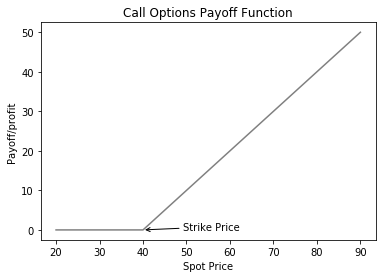

In [0]:
s = np.arange(20, 100, 10)
k = 40
plt.plot(s, np.where(s > k, s-k, 0), c='grey')
plt.annotate("Strike Price", (40,0),textcoords='offset points', arrowprops=dict(arrowstyle="->"))
plt.xlabel("Spot Price")
plt.ylabel("Payoff/profit")
plt.title("Call Options Payoff Function")
plt.show()

# Data Preprocessing

In [0]:
def load_data():
    '''loads data WRDS data and preprocessing it for ML algos
    
    Args:
      None
    Returns:
      dataframe: preprocessed data
    '''
    options = pd.read_csv("option_metrics.csv")
    options = options[options.volume >= 50]
    stocks = pd.read_csv("stock_data.csv")
    rates = pd.read_csv('DGS10.csv')
    rates.DATE = pd.to_datetime(rates.DATE)
    rates.DGS10 = pd.to_numeric(rates.DGS10, errors='coerce')
    rates = rates.fillna(method='bfill')
    rates.rename({"DATE":"date", 'DGS10':'r'}, axis=1, inplace=True)
    stocks["Date"] = pd.to_datetime(stocks["Date"], format="%b %d, %Y")
    options['c'] = options.loc[:, ['best_bid', 'best_offer']].mean(1)
    low_bound_price = options.c.mean()*.05
    options = options[options.c > low_bound_price]
    options["date"] = pd.to_datetime(options["date"], format="%Y/%m/%d")
    options["exdate"] = pd.to_datetime(options["exdate"], format="%Y/%m/%d")
    stocks.rename({"Date":"date"}, axis=1, inplace=True)
    options.rename({'strike_price':'K'}, axis=1, inplace=True)
    stocks["S"] = stocks["Price"].str.replace(",","")
    stocks["S"] = pd.to_numeric(stocks["S"])
    options = pd.merge(options, stocks[["S", "date"]], on="date")
    options = pd.merge(options, rates, on="date")
    options.drop(options.columns[[2, 4, 5, 7, 8, 9, 10]], 1, inplace=True)
    #
    options["S/K"] = (options["S"]*1000)/options["K"]
    options["c/K"] = options['c']/(options["K"]/1000)
    options["ttm"] = (options["exdate"] - options["date"])/(pd.Timedelta(days=252))
    options = options[options.c >= (options.S - (options.K*np.exp(-options.r*options.ttm)))]
    options = options[((options['S/K'] > .85) & (options['S/K'] < 1.15)) & options.ttm>(15/252/2)]
    options["logX"] = np.log(options["S"]) - np.log(options["S"]).shift(1) 
    options["std"] = options["logX"].shift(1).rolling(len(options)//3, min_periods=126).std()
    options["r"] = options["r"]/(360*100)
    options["BlkS"] = BlkS(options["S"], options["K"]/1000, options["ttm"], options["r"], options["std"])/(options["K"]/1000)
    return options

In [0]:
options = load_data()
X = np.array(options[['S/K', 'ttm', 'BlkS']])
y = np.array(options['c/K'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=False)
BlkS_test = X_test[:,2] 
X_train, X_test = X_train[:,:2], X_test[:,:2]

In [0]:
len(options.iloc[8448:].K.unique())

72

In [0]:
print(mean_squared_error(y_test, BlkS_test))
print(np.sqrt(mean_squared_error(y_test, BlkS_test)))

8.407452303872737e-06
0.002899560708775165


# Linear Regression

In [0]:
def transform(deg=2):
    ''' used polynomial basis function to transform preprocessed data with varying degrees
        and splits data into training and test set

    Args:
      deg(int): the polynomial degress required for transformation
    
    Returns:
      tuple(array): returns transformed training and test set
    '''
    scaler = StandardScaler()
    Xtrain_poly = scaler.fit_transform(X_train)
    Xtest_poly = scaler.transform(X_test)
    poly_fit = PolynomialFeatures(deg)
    Xtrain_poly = poly_fit.fit_transform(X_train)
    Xtest_poly = poly_fit.fit_transform(X_test)
    return Xtrain_poly, Xtest_poly , y_train, y_test, X_test

In [0]:
def analyze_lin_reg():
    ''' used polynomial basis function to transform preprocessed data with varying degrees

    Args:
      None
    
    Returns:
      tuple(array): prediction and performance scores
    '''
    degs = np.arange(1, 6)
    methods = ['Ridge', 'Lasso', 'LinearRegression']
    data = transform()
    result = np.zeros((len(data[1]), len(degs)*len(methods)+1))
    result[:,0] = data[4][:,0]
    scores = np.zeros(len(degs)*len(methods)+1)
    alphas = {'alpha':np.logspace(-5, 5, 100)}
    i = 1
    for reg in methods:
        x = globals()[reg]()
        gs = GridSearchCV(x, alphas, cv=5)
        for deg in degs:
            X_train_p, X_test_p, y_train, y_test, _ = transform(deg)
            if reg != 'LinearRegression':
                gs.fit(X_train_p, y_train)
                best_a = gs.best_params_['alpha']
                x= globals()[reg](best_a)
                x.fit(X_train_p, y_train)
                result[:, i] = x.predict(X_test_p)
                scores[i-1] = x.score(X_test_p, y_test)
            else:
                x.fit(X_train_p, y_train)
                result[:, i] = x.predict(X_test_p)
                scores[i-1] = x.score(X_test_p, y_test)
            i += 1
    return result, scores

In [0]:
def plot_reg(pred, scores):
    ''' plots prediction annotated with the scores

    Args:
      pred(array): numpy array of price predictions
      scores(array): numpy array of performance scores
    Returns:
      None
    '''
    methods = ['Ridge', 'Lasso', 'LinearRegression']
    degs = np.arange(2, 11, 2)
    i = 1
    for method in methods:
        plt.figure(figsize=(20,4))
        for j, deg in zip(range(1,6), degs):
            plt.subplot(1,5,j)
            plt_x = np.sort(X_test[:, 0])
            plt.scatter(plt_x, y_test[X_test[:,0].argsort()],marker='x')
            plt.plot(plt_x, pred[:,i][X_test[:,0].argsort()], c='r', label="Score: "+str(round(scores[i-1],4)))
            plt.title(method+ ", degree = "+str(deg))
            plt.xlabel("Spot Price/K")
            plt.ylabel("Call Price/K")
            plt.legend()
            i += 1
        plt.show()

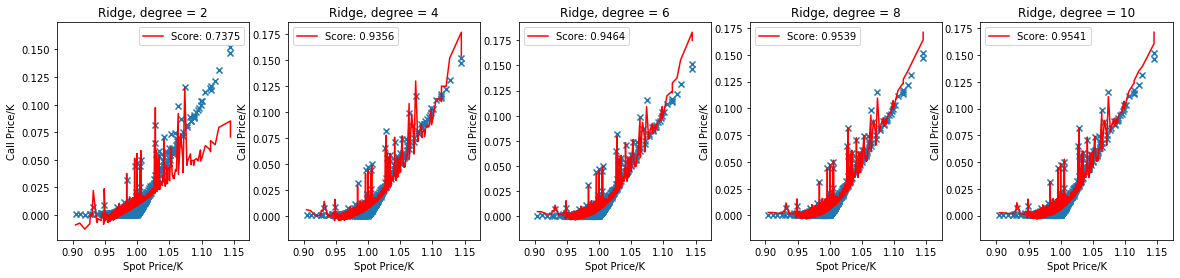

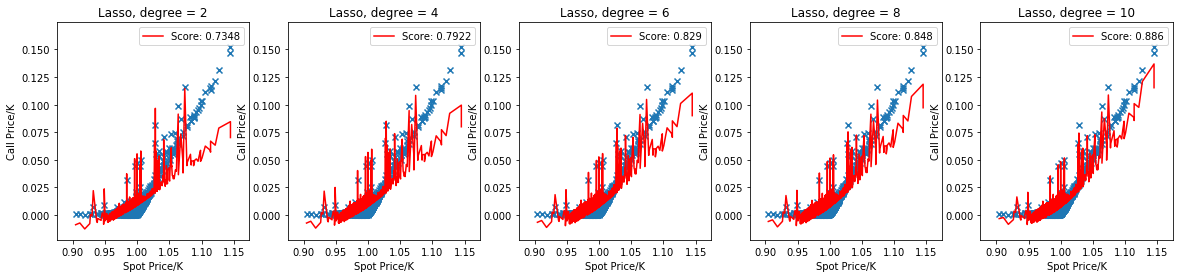

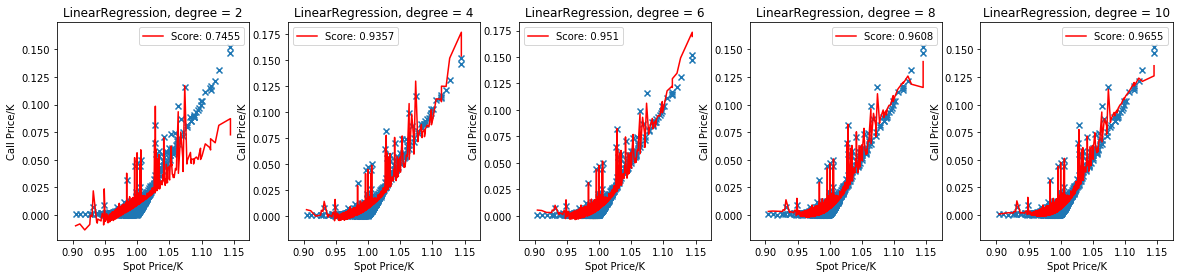

In [0]:
lr_pred, scores = analyze_lin_reg() 
plot_reg(lr_pred, scores)

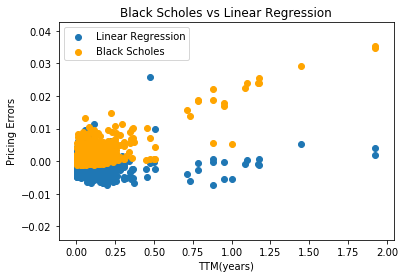

7.23439473181199e-06
0.002689683016976534


In [0]:
plt.scatter(X_test[:,1], y_test-lr_pred[:,15], label='Linear Regression')
plt.scatter(X_test[:,1], y_test-BlkS_test, c='orange', label='Black Scholes')
plt.xlabel('TTM(years)')
plt.ylabel('Pricing Errors')
plt.legend()
plt.title("Black Scholes vs Linear Regression")
plt.show()
print(mean_squared_error(y_test, lr_pred[:,15]))
print(np.sqrt(mean_squared_error(y_test, lr_pred[:,15])))

# Gaussian Process Regression (GPR)

In [0]:
def analyze_gpr():
    ''' performs gaussian process regression with varying hyperparameters

    Args:
      None
    
    Returns:
      array: prediction
    '''
  l = [1., .5]
  a = [1e-10, 2e-10]
  pred = np.zeros((len(X_test), 4))
  for i in range(2):
    for j in range(2):
      sk_kernel = gp.kernels.RBF(length_scale=l[i], length_scale_bounds=(1, 10))
      model = gp.GaussianProcessRegressor(kernel=sk_kernel,alpha=a[j], n_restarts_optimizer=20)
      model.fit(X_train, y_train)
      pred[:,i] = model.predict(X_test)
  return pred
def plot_gpr(pred):
    ''' plots prediction annotated with the scores

    Args:
      pred(array): numpy array of price predictions
    Returns:
      None
    '''
    l_a = [1., 1e-10,  .5, 2e-10, .5, 1e-10, 1., 2e-10 ]
    plt.figure(figsize=(25,5))
    for i in range(4):
      plt.subplot(1,4,i+1)
      plt_x = np.sort(X_test[:, 0])
      plt.scatter(plt_x, y_test[X_test[:,0].argsort()],marker='x')
      plt.plot(plt_x, pred[:,i][X_test[:,0].argsort()], c='r', label=round(r2_score(y_test, pred[:,i]),4))
      plt.title("l = "+str(l_a[2*i])+ ", a = "+str(l_a[2*i+1]))
      plt.xlabel("Spot Price/K")
      plt.ylabel("Call Price/K")
      plt.legend()
    plt.show()

In [0]:
gpr_pred = analyze_gpr()

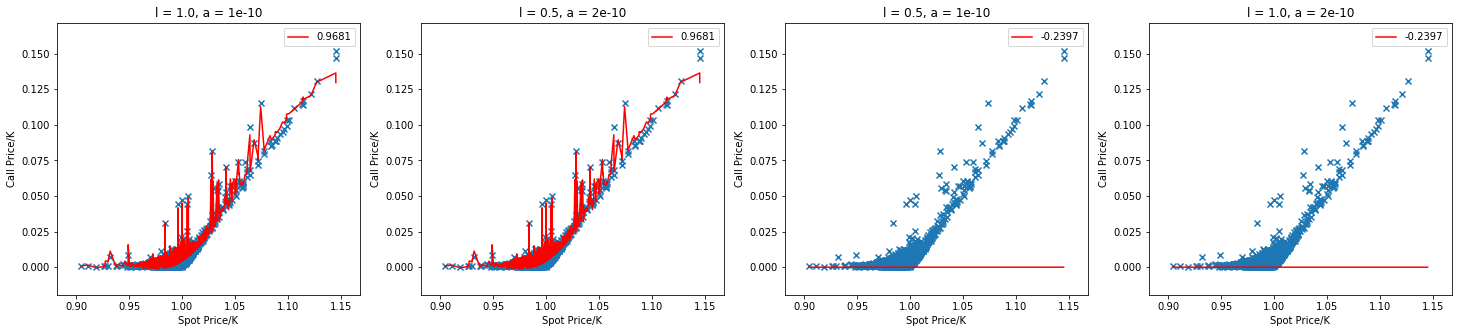

In [0]:
plot_gpr(gpr_pred)

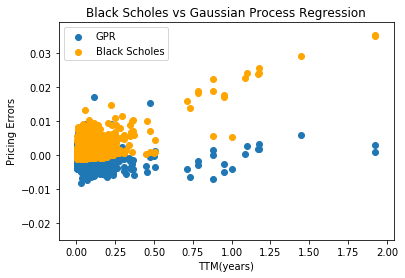

6.684191889202959e-06
0.002585380414794496


In [0]:
plt.scatter(X_test[:,1], y_test-gpr_pred[:,0], label='GPR')
plt.scatter(X_test[:,1], y_test-BlkS_test, c='orange', label='Black Scholes')
plt.xlabel('TTM(years)')
plt.ylabel('Pricing Errors')
plt.legend()
plt.title("Black Scholes vs Gaussian Process Regression")
plt.show()
print(mean_squared_error(y_test, gpr_pred[:,1]))
print(np.sqrt(mean_squared_error(y_test, gpr_pred[:,1])))

# Random Forest Regression

In [0]:
def analyze_rndFrst(nodes=8):
    ''' performs random forest regression with varying number of leaf nodes and estimators

    Args:
      nodes(int): number of nodes to be used for regression
    
    Returns:
      tuple(array): prediction, scores
    '''
  n_est = [50, 400, 1000]
  pred = np.zeros((len(X_test), 3))
  scores = np.zeros(3)
  for i in range(3): 
    rndForestReg = RandomForestRegressor(n_estimators=n_est[i], max_leaf_nodes=nodes, n_jobs=-1)
    rndForestReg.fit(X_train, y_train)
    pred[:,i] = rndForestReg.predict(X_test)
    scores[i] = rndForestReg.score(X_test, y_test)
  return pred, scores
  
def plot_forest(pred, scores, node):
    ''' plots prediction annotated with the scores

    Args:
      pred(array): numpy array of price predictions
      scores(array): numpy array of performance scores
      node(int): nodes used for each random forest regression
    Returns:
      None
    '''
    n_tress = [50, 400, 1000]
    plt.figure(figsize=(20,5))
    print(scores)
    for i in range(3):
      plt.subplot(1,3,i+1)
      plt_x = np.sort(X_test[:, 0])
      plt.scatter(plt_x, y_test[X_test[:,0].argsort()],marker='x')
      plt.plot(plt_x, pred[:,i][X_test[:,0].argsort()], c='r', label=str(round(scores[i],4)))
      plt.legend()
      plt.title("No of Nodes = "+str(node)+", No of trees = "+str(n_tress[i]))
      plt.xlabel("Spot Price/K")
      plt.ylabel("Call Price/K")
    plt.show()

[0.92820145 0.92758954 0.92726366]


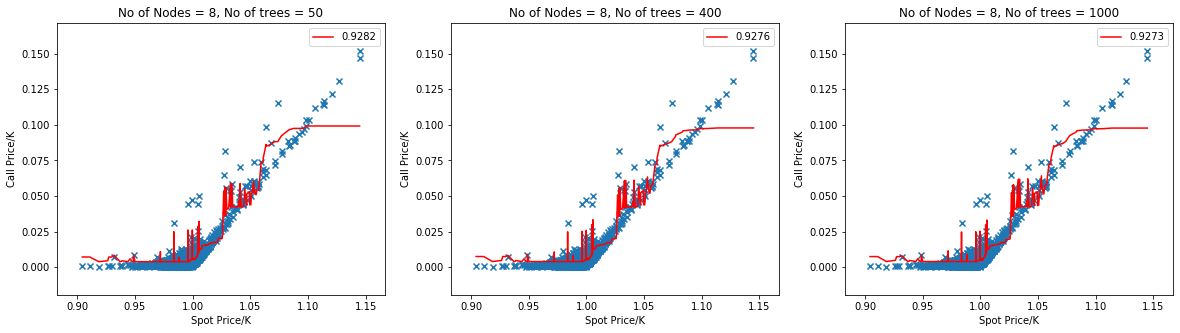

[0.96279994 0.9627247  0.96316392]


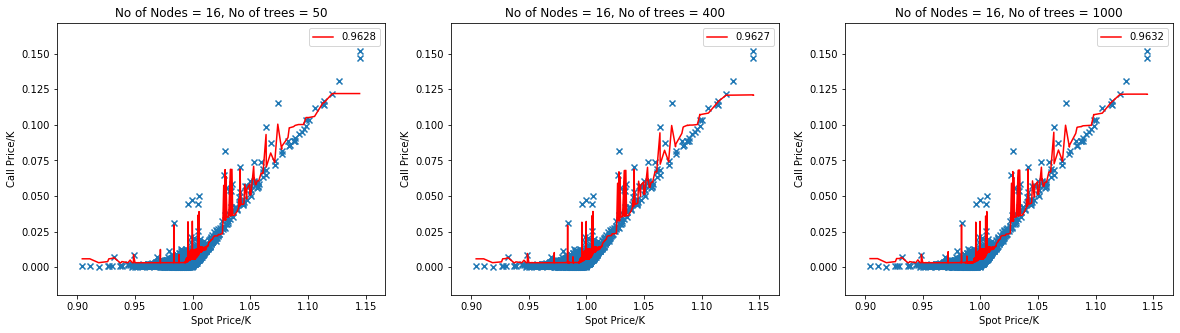

[0.97317799 0.97446344 0.97442026]


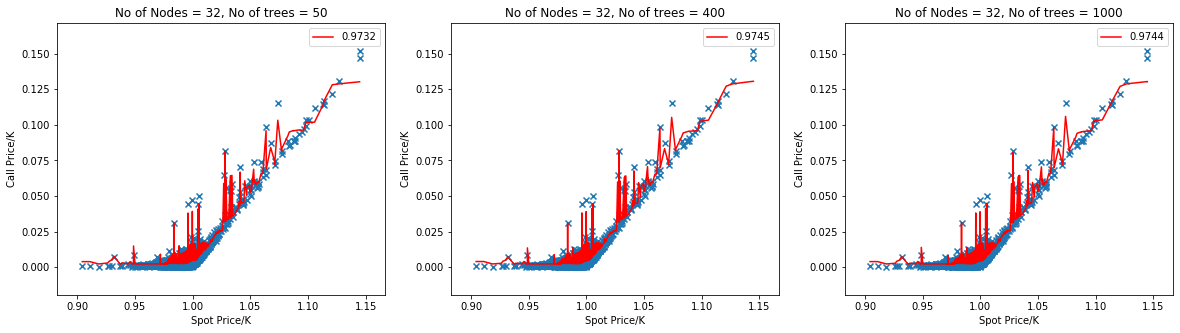

In [0]:
nodes = [8, 16, 32]
rnd_forestsreg = [0, 0, 0]
for i, node in zip(range(3), nodes):
  pred, scores = analyze_rndFrst(node)
  rnd_forestsreg[i] = pred
  plot_forest(pred, scores, node)


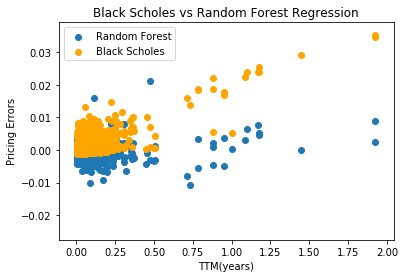

5.374231151362461e-06
0.0023182388037824016


In [0]:
rf_pred, _ =  analyze_rndFrst(32)
plt.scatter(X_test[:,1], y_test-rf_pred[:,0], label='Random Forest')
plt.scatter(X_test[:,1], y_test-BlkS_test, c='orange', label='Black Scholes')
plt.xlabel('TTM(years)')
plt.ylabel('Pricing Errors')
plt.legend()
plt.title("Black Scholes vs Random Forest Regression")
plt.show()
print(mean_squared_error(y_test, rf_pred[:,1]))
print(np.sqrt(mean_squared_error(y_test, rf_pred[:,1])))

# Artificial Neural Networks

In [0]:
def analyze_nn():
    ''' performs deep neural networks with varying hyperparameters

    Args:
      None
    
    Returns:
      tuple(array, loss): prediction, mean squared errors
    '''
  actv_func = ['relu', 'sigmoid', 'softplus']
  pred = np.zeros((len(X_test), 4))
  loss = np.zeros(4)
  for i in range(3):
    func1 = actv_func[i] if i != 2 else np.random.choice(actv_func)
    func2 = actv_func[i] if i != 2 else np.random.choice(actv_func)
    func3 = actv_func[i] if i != 2 else np.random.choice(actv_func)
    n_neurons = [20, 40, 60, 80]
    n1, n2, n3, n4 = n_neurons if i  != 3 else np.random.random_integers(20, 80,size=4)
    model = tf.keras.Sequential([
                                keras.layers.Dense(units=1, input_shape=[2]),
                                keras.layers.Dense(n1, activation='sigmoid', use_bias=True, input_shape=[1]),
                                keras.layers.Dense(n2, activation=func1, use_bias=True, input_shape=[1]),
                                keras.layers.Dense(n3, activation=func2, use_bias=True, input_shape=[1]),
                                keras.layers.Dense(n4, activation=func3, use_bias=True, input_shape=[1]),
                                keras.layers.Dense(1, activation='softplus', use_bias=True)
                                ])
    model.compile(optimizer='nadam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=500)
    pred[:, i] = model.predict(X_test)[:, 0]
    loss[i] = mean_squared_error(y_test, pred[:, i])
  return pred, loss

def plot_nn(pred, scores):
  funcs = ['Relu Activation Function', 'Sigmoid Activation Function', 'Random Mixture of Activation Function', 'Random Mixture of Activation Function and Neurons']
  plt.figure(figsize=(22,5))
  for i in range(3):
    plt.subplot(1,4,i+1)
    plt_x = np.sort(X_test[:, 0])
    plt.scatter(plt_x, y_test[X_test[:,0].argsort()],marker='x')
    score = r2_score(y_test, pred[:,i])
    plt.plot(plt_x, pred[:,i][X_test[:,0].argsort()], c='r', label=str(round(score,4)))
    plt.legend()
    plt.title(funcs[i])
    plt.xlabel("Spot Price/K")
    plt.ylabel("Call Price/K")
  plt.show()

In [0]:
nn_pred, scores = analyze_nn()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 8448 samples
Epoch 1/500
8448/8448 [==============================] - 6s 691us/sample - loss: 0.0127
Epoch 2/500
8448/8448 [==============================] - 1s 139us/sample - loss: 1.9210e-04
Epoch 3/500
8448/8448 [==============================] - 1s 144us/sample - loss: 1.8949e-04
Epoch 4/500
8448/8448 [==============================] - 1s 139us/sample - loss: 1.8078e-04
Epoch 5/500
8448/8448 [==============================] - 1s 142us/sample - loss: 1.6700e-04
Epoch 6/500
8448/8448 [==============================] - 1s 145us/sample - loss: 1.6016e-04
Epoch 7/500
8448/8448 [==============================] - 1s 146us/sample - loss: 1.5969e-04
Epoch 8/500
8448/8448 [==============================] - 1s 142us/sample - loss: 1.6342e-04
Epoch 9/500
8448/8448 [==============================] - 1s 151us/sample - loss: 1.6059e-04
Epoch 10/500
8448/8448 [==============================] - 1s 148us/sample

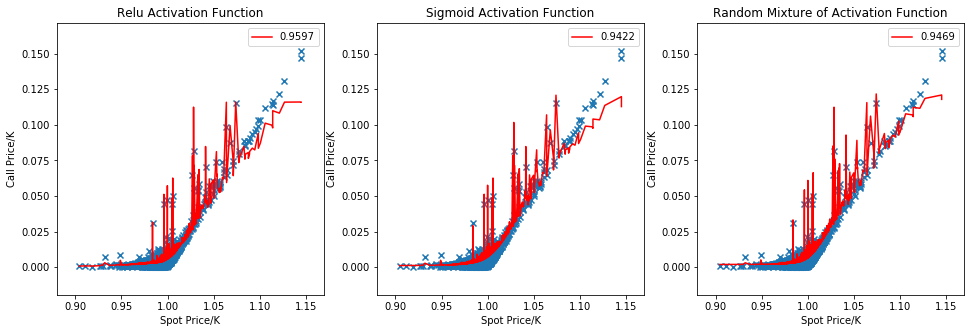

In [0]:
plot_nn(nn_pred, scores)

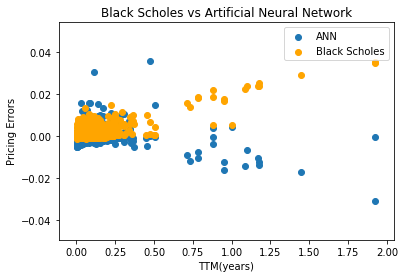

8.451330169580284e-06
0.00290711715786968


In [0]:
plt.scatter(X_test[:,1], y_test-nn_pred[:,0], label='ANN')
plt.scatter(X_test[:,1], y_test-BlkS_test, c='orange', label='Black Scholes')
plt.xlabel('TTM(years)')
plt.ylabel('Pricing Errors')
plt.legend()
plt.title("Black Scholes vs Artificial Neural Network")
plt.show()
print(mean_squared_error(y_test, nn_pred[:,0]))
print(np.sqrt(mean_squared_error(y_test, nn_pred[:,0])))